In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# clustering functions
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster import hierarchy

# SARIMA model and autocorrelation plots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# SARIMA model throws lots of MLE convergence errors
import warnings
warnings.filterwarnings("ignore")

### Initialization

The following cells load and prep the data. To simplify the analysis, only 2015 data is included.

In [17]:
# read meta and demand data from csv into new dataframes, then fix datetimes
meta = pd.read_csv('../input/meta_open.csv',index_col=0)
meta['datastart'] = pd.to_datetime(meta['datastart'],format='%d/%m/%y %H:00')
meta['dataend'] = pd.to_datetime(meta['dataend'],format='%d/%m/%y %H:00')

raw = pd.read_csv('../input/temp_open_utc_complete.csv',index_col=0)
raw.index = pd.to_datetime(raw.index,format='%Y-%m-%d %H:00:00+00:00')

In [18]:
# find buildings that have data starting on Jan 1
good_buildings = []
good_starts = ['2015-01-01 00:00:00']

for building in meta.index:
    start = str(meta['datastart'][building])
    if start in good_starts:
        good_buildings.append(building)

# number of buildings that have complete data starting at Jan 1
len(good_buildings)

225

In [19]:
# remove leap day for simplicity
no_leap_days = raw.drop(pd.date_range(start='2012-02-29 00:00:00',periods=24,freq='H'))

# initialize a new dataframe with all demand values matched up
demand = pd.DataFrame()

for building in good_buildings:
    demand[building] = no_leap_days[building].dropna().values

demand.index = pd.date_range(start='2015-01-01 00:00:00',periods=8760,freq='H')

### Exploration

Plots of aggregate demand for the office buildings, followed by hour-of-day and day-of-week clustering.

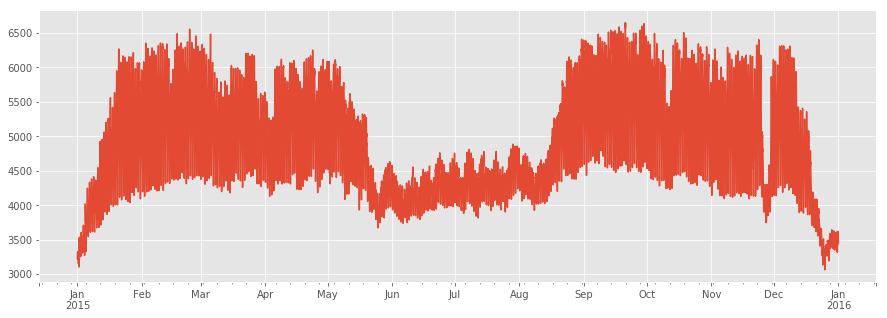

In [20]:
# identify offices and dorms
office_names = [k for k in demand.columns if 'Office' in k]
dorm_names = [k for k in demand.columns if 'Dorm' in k]
lab_names = [k for k in demand.columns if 'Lab' in k]
classroom_names = [k for k in demand.columns if 'Class' in k]

# create dataframes of each building type
offices = pd.Series(demand[office_names].sum(axis=1))
dorms = pd.Series(demand[dorm_names].sum(axis=1))
labs = pd.Series(demand[lab_names].sum(axis=1))
classrooms = pd.Series(demand[classroom_names].sum(axis=1))

dorms.plot(figsize=(15,5))

The following cells implement hierarchical agglomerative clustering on the hour-of-day and day-of-week profiles of the office buildings.

In [21]:
# calculate the average day-of-week and hour-of-day profiles, then apply sklearn minmaxscaler
scaler = MinMaxScaler()

offices_all = pd.DataFrame(demand[office_names])
hour_of_day = offices_all.groupby(offices_all.index.hour).sum()
day_of_week = offices_all.groupby(offices_all.index.dayofweek).sum()

hour_of_day_norm = pd.DataFrame(scaler.fit_transform(hour_of_day.values),columns=hour_of_day.columns)
day_of_week_norm = pd.DataFrame(scaler.fit_transform(day_of_week.values),columns=day_of_week.columns)

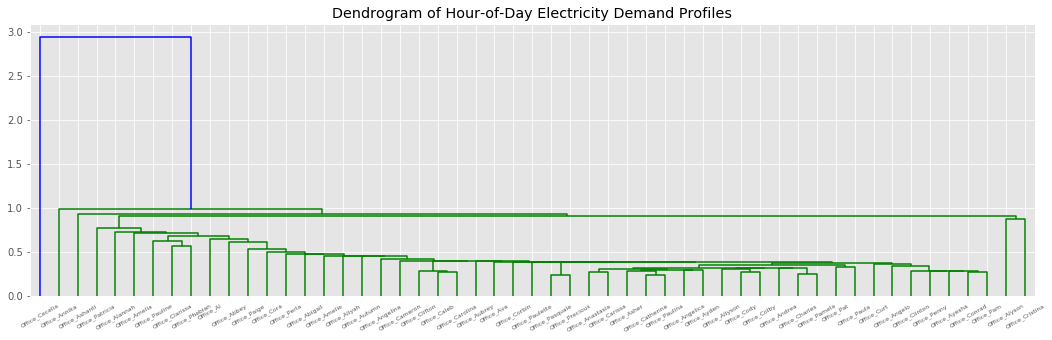

In [22]:
linked = hierarchy.linkage(hour_of_day_norm.values.T,'single')
labels = hour_of_day_norm.columns

plt.figure(figsize=(18, 5))
hierarchy.dendrogram(linked,orientation='top',labels=labels,distance_sort='descending',)
plt.xticks(rotation=30)
plt.title('Dendrogram of Hour-of-Day Electricity Demand Profiles')
plt.show()

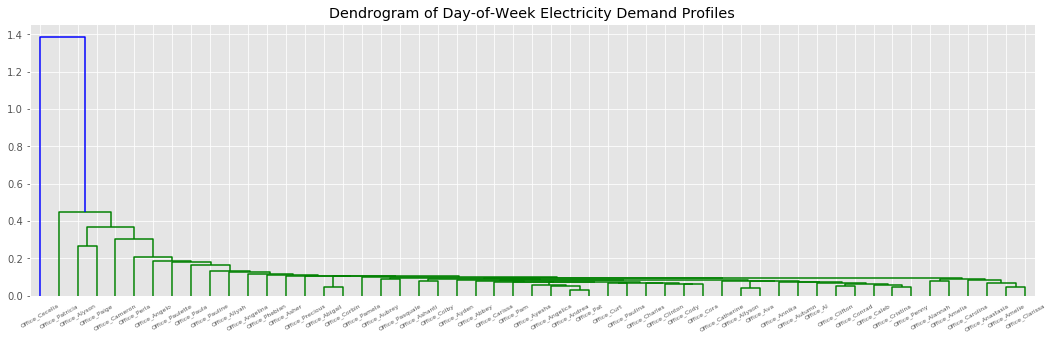

In [23]:
# repeat the dendrogram for the day-of-week curves
linked = hierarchy.linkage(day_of_week_norm.values.T,'single')
labels = day_of_week_norm.columns

plt.figure(figsize=(18,5))
hierarchy.dendrogram(linked,orientation='top',labels=labels,distance_sort='descending')
plt.xticks(rotation=30)
plt.title('Dendrogram of Day-of-Week Electricity Demand Profiles')
plt.show()

### Transformation of median-shifting features

Many predictive models require stationary data. Electricity demand data is never stationary, because it includes seasonal (daily, weekly, yearly) effects as well as trend (steady/exponetial increase) effects.

The following cells make the data stationary by calculating and then removing the hour-of-week (weekend vs weekday) and week-of-year (spring break vs class in session) effects.

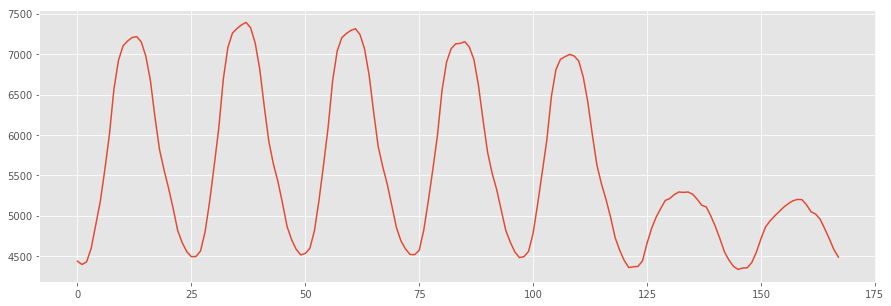

In [24]:
# calculate hour-of-week and week-of-year averages to isolate weekend, holiday median-shifting
hourofweekarray, hourofweek = range(168),range(72,168) # the year starts on thursday
while len(hourofweek) < 10000: hourofweek = np.append(hourofweek,hourofweekarray)
hourofweek = hourofweek[:8760]

office_week = offices.groupby(hourofweek).mean()
office_week_transformer = np.vectorize(office_week.to_dict().get)(hourofweek)

office_year = offices.groupby(offices.index.weekofyear).mean()
office_year_transformer = offices.index.weekofyear.map(office_year)

# plot average hour-of-week to demonstrate the transformer
office_week.plot(figsize=(15,5),x='Hour of Week',y='kW')

As you can see in the "stationary" plot below, the transformations used do not accurately remove the effects of holidays shorter than one week, like the 4th of July, Thanksgiving, Christmas. To improve the model, these could be hard-coded or identified by clustering with weekends over multiple years of data.

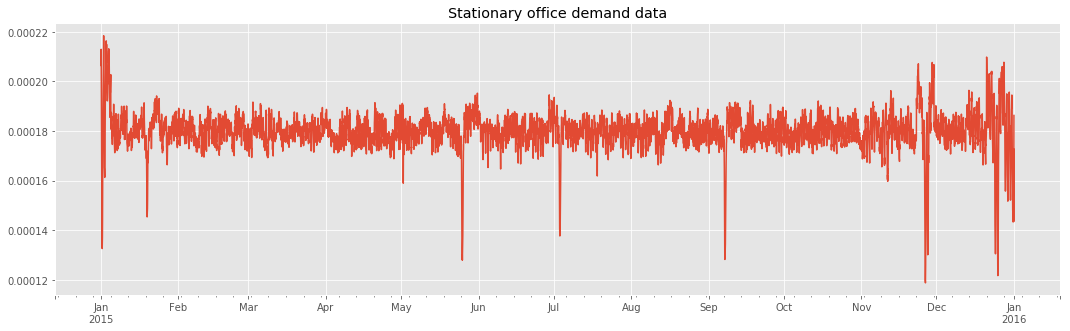

In [25]:
offices_stationary = offices/office_week_transformer/office_year_transformer
offices_stationary.plot(figsize=(18,5),title='Stationary office demand data')

### Autocorrelation plots

The plots below show the autocorrelation and partial autocorrelation of the raw demand data. The shaded red cone shows the 95% confidence interval, meaning all dots outside of the cone are statistically significant. The dots themselves represent lag features, where the first dot is lag by one hour, and the second by two hours.

Following the Box-Jenkins methodology, these plots can be used to inform the type of ARIMA model to be used. https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

See how the 24th and 48th lag features have a strong positive correlation - this indicates that a seasonal component of 24 hours should be modeled.

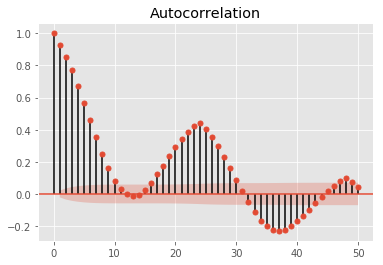

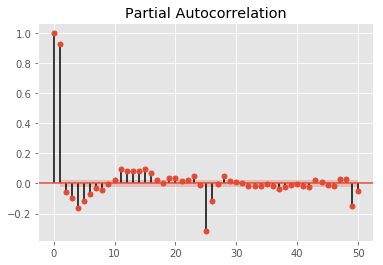

In [26]:
plot_acf(offices_stationary, lags=50)
plt.show()
plot_pacf(offices_stationary, lags=50)
plt.show()

### Predictive Modeling: Seasonal ARIMA

The SARIMA (seasonal autoregressive integrated moving average) model has four parameters: P,D,Q, and m. P,D, and Q are the *seasonal* autoregressive, differencing, and moving average terms, while m is the period. For the demand data, m should be 24. SARIMA also supports trend terms, but there is no trend in this data, so they will not be used.

The cells below train and test SARIMA models for several days in of the training set, starting on February 1st. The MAPE of each daily forecast is stored in the mapes DataFrame, and the predictions are stored in the y_forecast Series.

In [27]:
# model parameters
num_days = 300
trend_params = (0,0,0)
seasonal_params = (1,0,1,24)

# rename offices dataframe to easily substitute into this model, which was written for y
y = offices.copy(deep=True)
y_stationary = offices_stationary.copy(deep=True)

# construct empty dataframe to populate with results
mapes = pd.DataFrame(columns=['hours_trained','mape'])
y_forecast_stationary = y_stationary.copy(deep=True)

# define split times and end times to cut X and y into training and testing sets
split_times = pd.date_range(start='2015-02-01 08:00:00',freq='D',periods=num_days)
end_times = split_times.shift(39,freq='H')

In [28]:
# loop to run models and add hours_trained & mape data to the mapes dataframe
for i in range(len(split_times)):
    
    # define training and testing sets based on split_times and end_times
    y_train = y_stationary.loc[y.index <= split_times[i]].copy().values
    y_test = y_stationary.loc[(y.index > split_times[i]) & (y.index <= end_times[i])].copy()

    # fit the model training data, then make multi-step out-of-sample forecast
    model = SARIMAX(y_train, order=trend_params,seasonal_order=seasonal_params,enforce_stationarity=False)
    model_fit = model.fit(disp=0,maxiter=200)
    forecast = model_fit.forecast(steps=39)
    
    # store the forecast results
    y_pred = forecast
    y_forecast_stationary.loc[(y.index > split_times[i]) & (y.index <= end_times[i])] = y_pred
    
    # calculate and store the mape, then move on to the next day
    hours_trained = len(y_train)
    mape = np.mean(np.abs((y_test[15:] - y_pred[15:]) / y_test[15:]))*100
    mapes = mapes.append({'hours_trained':hours_trained,'mape':mape},ignore_index=True)

print('The average MAPE for {} test days was {}'.format(len(mapes),np.round(np.mean(mapes['mape']),2)))

The average MAPE for 300 test days was 2.5


In [29]:
# reverse the transformations
y_forecast = y_forecast_stationary*office_year_transformer*office_week_transformer

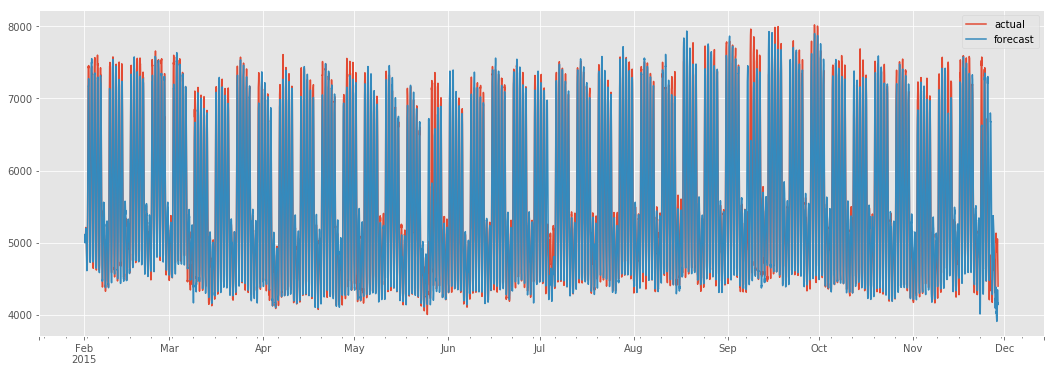

In [30]:
# plot all of the day-ahead forecasts against the actual data
entire_forecast = pd.DataFrame({'actual':y[split_times[0]:end_times[i]],
                                'forecast':y_forecast[split_times[0]:end_times[i]]}
                              )
entire_forecast.plot(figsize=(18,6))